## ADAM

Combining Adaptive Learning rates with momentum


In [6]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df = pd.read_csv('/content/linreg-data.csv', index_col=0)

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

torch.manual_seed(123)

shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)

X=X[shuffle_idx]
y=y[shuffle_idx]

percent70=int(X.shape[0]*0.7)

X_train=X[:percent70]
y_train=y[:percent70]

X_test=X[percent70:]
y_test=y[percent70:]

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

 Below is an implementation of Linear Regression where we have used normal SGD


In [8]:
class LinearRegression01(torch.nn.Module):

  def __init__(self,num_features):
    super(LinearRegression01, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)


    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):

    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):

    torch.manual_seed(120)
    loss=[]
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])

        optimizer.zero_grad()
        mse.backward()
        optimizer.step()

      with torch.no_grad():

        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss

## ADAM - Combining Adaptive Learning Rates with Momentum

The main idea behind the Adam optimizer is to combine the benefits of **adaptive learning rates** (like those in RMSprop) with **momentum** (like in the momentum variant of gradient descent). It computes adaptive learning rates for each parameter from estimates of first and second moments of the gradients, while also using momentum to smooth out updates and speed up convergence.

In simple terms, Adam uses both the moving average of the gradients and the squared gradients to adapt the learning rates for each parameter. Additionally, it incorporates momentum to improve the updates by retaining information about past gradients.

### Key Concepts:
- **m_w** and **m_b** are the **first moment estimates** for the weights and bias. These represent the moving averages of the gradients, helping to accelerate the descent in the correct direction.
  
- **v_w** and **v_b** are the **second moment estimates** for the weights and bias. These represent the moving averages of the squared gradients, helping to adjust the learning rates for each parameter.

- **beta1** is the **decay factor for the first moment** (momentum term), controlling how much past gradients are retained.
  
- **beta2** is the **decay factor for the second moment**, controlling how much past squared gradients are retained.

- **epsilon** is a small constant added for numerical stability to avoid division by zero when normalizing the gradients.

### Equations:
1. **First Moment Estimate Update**:

   m_w = beta1 * m_w + (1 - beta1) * grad_w  
   m_b = beta1 * m_b + (1 - beta1) * grad_b  

   Where:
   - m_w, m_b are the first moment estimates for the weights and bias.
   - beta1 is the decay factor for the first moment.
   - grad_w, grad_b are the gradients of the loss with respect to weights and bias.

2. **Second Moment Estimate Update**:

   v_w = beta2 * v_w + (1 - beta2) * (grad_w^2)  
   v_b = beta2 * v_b + (1 - beta2) * (grad_b^2)  

   Where:
   - v_w, v_b are the second moment estimates for the weights and bias.
   - beta2 is the decay factor for the second moment.
   - grad_w, grad_b are the gradients of the loss with respect to weights and bias.

3. **Bias Correction** (to counteract the initialization bias in the moving averages):

   m_w_hat = m_w / (1 - beta1^t)  
   m_b_hat = m_b / (1 - beta1^t)  
   v_w_hat = v_w / (1 - beta2^t)  
   v_b_hat = v_b / (1 - beta2^t)  
    
  Where:
   - m_w_hat, m_b_hat are the bias-corrected first moment estimates.
   - v_w_hat, v_b_hat are the bias-corrected second moment estimates.
   - t is the current timestep (or epoch).

4. **Parameter Update**:

   w = w - lr * m_w_hat / sqrt(v_w_hat + epsilon)  
   b = b - lr * m_b_hat / sqrt(v_b_hat + epsilon)  

   Where:
   - w, b are the weight and bias parameters.
   - lr is the learning rate.
   - epsilon is a small constant added for numerical stability.


In [13]:
class LinearRegression02(torch.nn.Module):

  def __init__(self,num_features):
    super(LinearRegression02, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)

    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):

    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10,beta1=0.9,beta2=0.9):
    torch.manual_seed(120)
    loss=[]
    epsilon=1e-10

    m_w=torch.zeros_like(self.linear.weight)
    v_w=torch.zeros_like(self.linear.weight)
    v_b=torch.zeros_like(self.linear.bias)
    m_b=torch.zeros_like(self.linear.bias)

    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])
        grad_w=grad(mse,self.linear.weight,retain_graph=True)[0]
        grad_b=grad(mse,self.linear.bias)[0]

        m_w=beta1*(m_w)+(1-beta1)*grad_w
        m_b=beta1*(m_b)+(1-beta1)*grad_b
        v_w=beta2*(v_w)+(1-beta2)*(grad_w**2)
        v_b=beta2*(v_b)+(1-beta2)*(grad_b**2)

        m_w_hat=m_w/(1-beta1**(epoch+1))
        m_b_hat=m_b/(1-beta1**(epoch+1))
        v_w_hat=v_w/(1-beta2**(epoch+1))
        v_b_hat=v_b/(1-beta2**(epoch+1))


        with torch.no_grad():
          self.linear.weight-=lr*m_w_hat/torch.sqrt(v_w_hat+epsilon)
          self.linear.bias-=lr*m_b_hat/torch.sqrt(v_b_hat+epsilon)

      with torch.no_grad():
        preds=self.forward(X)
        epoch_loss=F.mse_loss(preds, y)
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss}')
        loss.append(epoch_loss)
    return loss






In [14]:
linear_regression=LinearRegression01(num_features=X.shape[1])
loss_without_adam=linear_regression.train(X_train,y_train,100,lr=0.01)

Epoch: 1, Loss: 472.7065734863281
Epoch: 2, Loss: 388.48199462890625
Epoch: 3, Loss: 384.5899963378906
Epoch: 4, Loss: 384.4708557128906
Epoch: 5, Loss: 384.50311279296875
Epoch: 6, Loss: 384.38348388671875
Epoch: 7, Loss: 384.35626220703125
Epoch: 8, Loss: 384.7010192871094
Epoch: 9, Loss: 384.4432678222656
Epoch: 10, Loss: 384.4690246582031
Epoch: 11, Loss: 384.48358154296875
Epoch: 12, Loss: 384.4710388183594
Epoch: 13, Loss: 384.39892578125
Epoch: 14, Loss: 384.427490234375
Epoch: 15, Loss: 384.5412902832031
Epoch: 16, Loss: 384.3504943847656
Epoch: 17, Loss: 384.3441467285156
Epoch: 18, Loss: 384.38262939453125
Epoch: 19, Loss: 384.57110595703125
Epoch: 20, Loss: 384.4284973144531
Epoch: 21, Loss: 384.5216979980469
Epoch: 22, Loss: 384.5309753417969
Epoch: 23, Loss: 384.79119873046875
Epoch: 24, Loss: 384.43328857421875
Epoch: 25, Loss: 384.3867492675781
Epoch: 26, Loss: 384.6307067871094
Epoch: 27, Loss: 384.42572021484375
Epoch: 28, Loss: 384.56976318359375
Epoch: 29, Loss: 384.

In [15]:
linear_regression_with_rmsprop=LinearRegression02(num_features=X.shape[1])
loss_with_adam=linear_regression_with_rmsprop.train(X_train,y_train,100)

Epoch: 1, Loss: 1842.5653076171875
Epoch: 2, Loss: 1733.271240234375
Epoch: 3, Loss: 1645.658935546875
Epoch: 4, Loss: 1569.631591796875
Epoch: 5, Loss: 1502.783203125
Epoch: 6, Loss: 1442.9361572265625
Epoch: 7, Loss: 1386.4405517578125
Epoch: 8, Loss: 1332.7899169921875
Epoch: 9, Loss: 1283.87744140625
Epoch: 10, Loss: 1238.1851806640625
Epoch: 11, Loss: 1194.64306640625
Epoch: 12, Loss: 1152.1986083984375
Epoch: 13, Loss: 1112.638427734375
Epoch: 14, Loss: 1074.6646728515625
Epoch: 15, Loss: 1037.9332275390625
Epoch: 16, Loss: 1003.569091796875
Epoch: 17, Loss: 969.9915771484375
Epoch: 18, Loss: 937.9656982421875
Epoch: 19, Loss: 906.7127685546875
Epoch: 20, Loss: 876.87890625
Epoch: 21, Loss: 847.3534545898438
Epoch: 22, Loss: 819.3336791992188
Epoch: 23, Loss: 793.4579467773438
Epoch: 24, Loss: 767.7673950195312
Epoch: 25, Loss: 743.1043090820312
Epoch: 26, Loss: 720.0639038085938
Epoch: 27, Loss: 697.7665405273438
Epoch: 28, Loss: 675.8456420898438
Epoch: 29, Loss: 654.9064941406

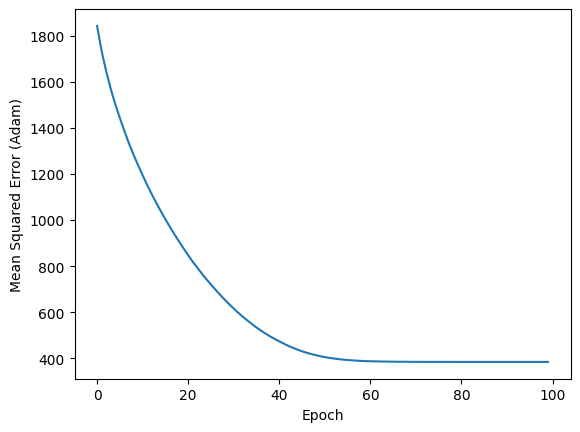

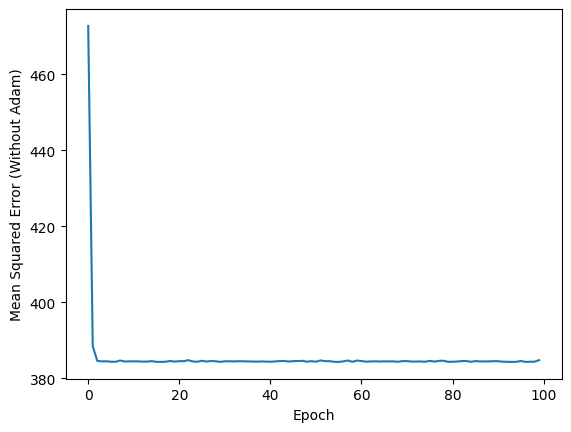

In [16]:
plt.plot(range(len(loss_with_adam)), loss_with_adam)
plt.ylabel('Mean Squared Error (Adam)')
plt.xlabel('Epoch')
plt.show()



plt.plot(range(len(loss_without_adam)), loss_without_adam)
plt.ylabel('Mean Squared Error (Without Adam)')
plt.xlabel('Epoch')
plt.show()